In [19]:
!pip install --upgrade imbalanced-learn==0.10.1

In [20]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
data_dir = "/kaggle/input/vgg-16datscan-ppmi/DAT-SEGREGATION"
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 100  

print(os.listdir(data_dir))


['NONPD', 'PD']


In [22]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  
)


train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 1112 images belonging to 2 classes.
Found 276 images belonging to 2 classes.


In [23]:
X_train, y_train = [], []

for i in range(len(train_data)):
    X_batch, y_batch = train_data[i]
    X_train.append(X_batch)
    y_train.append(y_batch)
    if len(X_train) * BATCH_SIZE >= train_data.samples:
        break

X_train = np.vstack(X_train)
y_train = np.vstack(y_train)

In [24]:
n_samples, h, w, c = X_train.shape
X_train_flat = X_train.reshape(n_samples, -1)

y_train_int = np.argmax(y_train, axis=1)

smote = SMOTE(random_state=42)
X_res, y_res_int = smote.fit_resample(X_train_flat, y_train_int)

X_res = X_res.reshape(-1, h, w, c)

num_classes = y_train.shape[1]
y_res = to_categorical(y_res_int, num_classes=num_classes)

print(f"Before SMOTE: {np.bincount(y_train_int)}")
print(f"After SMOTE: {np.bincount(y_res_int)}")

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

Before SMOTE: [196 916]
After SMOTE: [916 916]


In [29]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-30:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

num_classes = train_data.num_classes
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,89

 Total params: 14,881,218 (56.77 MB)

 Trainable params: 14,880,194 (56.76 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [31]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-6)

In [32]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
)


Epoch 1/100


I0000 00:00:1761672389.166869     197 service.cc:148] XLA service 0x7de5e4003a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761672389.167945     197 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761672389.167968     197 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761672389.978538     197 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-10-28 17:26:34.960254: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[8,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_s

139/139 ━━━━━━━━━━━━━━━━━━━━ 71s 287ms/step - accuracy: 0.7775 - loss: 0.5246 - precision_1: 0.7775 - recall_1: 0.7775 - val_accuracy: 0.8261 - val_loss: 9.2042 - val_precision_1: 0.8261 - val_recall_1: 0.8261 - learning_rate: 3.0000e-04
Epoch 2/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - accuracy: 0.7810 - loss: 0.4682 - precision_1: 0.7810 - recall_1: 0.7810 - val_accuracy: 0.8261 - val_loss: 0.8627 - val_precision_1: 0.8261 - val_recall_1: 0.8261 - learning_rate: 3.0000e-04
Epoch 3/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - accuracy: 0.8224 - loss: 0.4480 - precision_1: 0.8224 - recall_1: 0.8224 - val_accuracy: 0.8261 - val_loss: 2.0918 - val_precision_1: 0.8261 - val_recall_1: 0.8261 - learning_rate: 3.0000e-04
Epoch 4/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - accuracy: 0.8204 - loss: 0.4620 - precision_1: 0.8204 - recall_1: 0.8204 - val_accuracy: 0.8261 - val_loss: 0.9680 - val_precision_1: 0.8261 - val_recall_1: 0.8261 - learning_rate: 3.0000e-04
Epoch 5/100


In [36]:
y_pred_prob = model.predict(val_data)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = val_data.classes

print(classification_report(y_true, y_pred, target_names=['NONPD', 'PD'], zero_division=0))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
              precision    recall  f1-score   support

       NONPD       0.60      0.58      0.59        48
          PD       0.91      0.92      0.91       228

    accuracy                           0.86       276
   macro avg       0.75      0.75      0.75       276
weighted avg       0.86      0.86      0.86       276

Confusion Matrix:
 [[ 28  20]
 [ 19 209]]


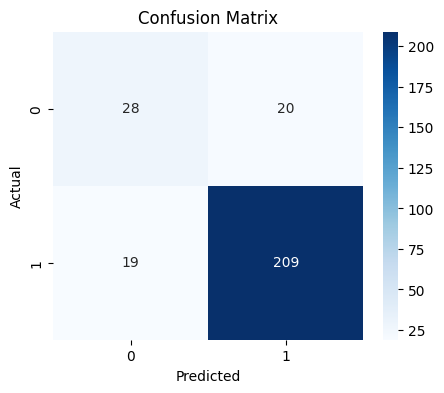

In [37]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


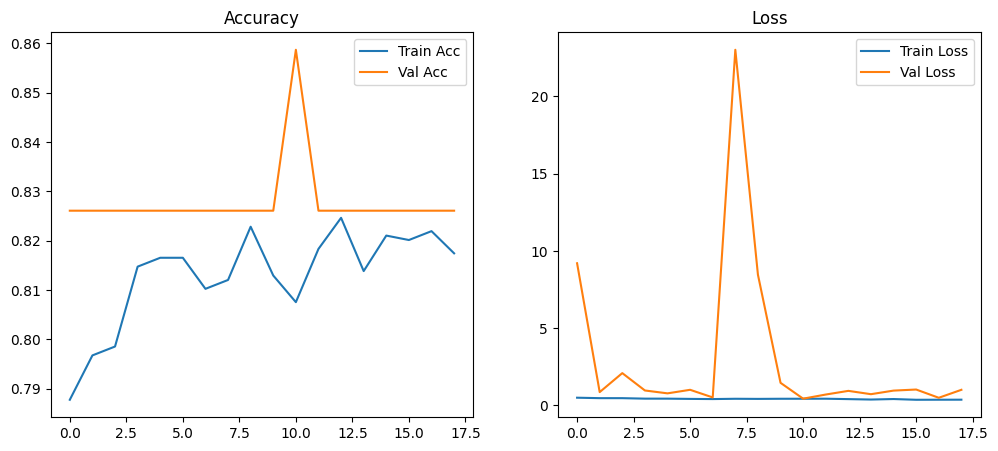

In [38]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()
